## Context

As explained by <a href="https://www.cs.toronto.edu/~hinton/FFA13.pdf">Hinton</a>, the Forward Forward (FF) Algorithm is a greedy multi-layer learning procedure which tries to replace the forward and backward passes of the backpropagation algorithm by using two forward passes instead.<br>
The main ideas are :
<ul>
    <li> A positive pass which operates on real data and adjusts the weights to increase the goodness in
every hidden layer
    <li> A negative pass which operates on negative data and adjusts the weights to decrease the goodness in every hidden layer.
    <li> The goodness is measured using the sum of the squared neural activities and the negative sum of the squared activities
    <li> The neural network objective is to make the goodness above some threshold for the positive data and below it for the negative ones.
    <li> Weights updates are performed within the layer itself
        
</ul>

### Goodness 

To measure the goodness, Hinton used the sum of the squared neural activities for two main reasons :

<ol>
    <li> It has very simple derivatives
    <li> Layer normalization removes all trace of the goodness
</ol>
So the goodness can be defined as :
$$ G(x) = \sum_{i=1}^{m}(ReLU(z_i))^2          \text{ where : }$$
<center>    
<ul>
    <li> $x$ is an input of a layer
    <li> $ReLU(z_i)$ is the activity of the neuron $i$ by applying a Rectified Linear Unit
    <li> $m$ is the number of neurons in the layer
</ul>
</center>

### Learning Objective

Our training objective is to predict whether an input instance is a positive data or a negative one by computing the following probability :

$$ p(x_{positive}) = \sigma(G(x) - \theta) \text{ where } \theta \text{ is a threshold and } \sigma \text{ is the logistic function}$$

Let's walk through the details by applying the algorithm to the MNIST dataset

## Implementation

In [1]:
import random
from pathlib import Path

import torch.nn as nn
import torch

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import cuda
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


torch.manual_seed(23)
random.seed(24)

### Data Preparation

In [2]:
# create a folder to save MNIST once for all
root = './data'
if not Path(root).is_dir():
    Path(root).mkdir()

# prepare and transform data 
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

X_train = MNIST(root=root, train=True, transform=trans, download=True)
X_test = MNIST(root=root, train=False, transform=trans, download=True)

train_loader = DataLoader(dataset=X_train, batch_size=len(X_train), shuffle=True)
test_loader = DataLoader(dataset=X_train, batch_size=len(X_test), shuffle=False)

### Building Positive and Negative Data

Positive data are created by linking to each input its true label. In contrast, the negative data are built by associating a random label to an input (one can use other methods to generate these data).<br>
As suggested by Hinton, one way of building positive and negative data is to add the label to each input. In our case, MNIST images contain a black border, so one can embed the labels by using the first ten pixels.

In [3]:
data_iter = iter(train_loader)
x, y = data_iter.next()

# get dimensions
n, _, d, _ = x.shape

# construct positive data
x_positive = x.clone()
maxi = x.max()

x_positive[range(n), 0, 0, y] = maxi

# construct negative data
x_negative = x.clone()
y_random = torch.randint(10, (n,))

# we want that each negative input contains a false label
force_randomness = True # turn to False to keep some true labels in negative data
if force_randomness:
    for i in range(n):
        if y_random[i] == y[i]:
            y_random[i] = random.choice(list(set([r for r in range(10)]) - set([y[i].item()])))

    # let's check if the randomness is forced
    assert any(y_random == y) == False

x_negative[range(n), 0, 0, y_random] = maxi

In [4]:
# prepare test data
data_test_iter = iter(test_loader)
x_test, y_test = data_test_iter.next()

# get dimensions
m, _, _, _ = x_test.shape

Let's visualize some samples from the new constructed images : 

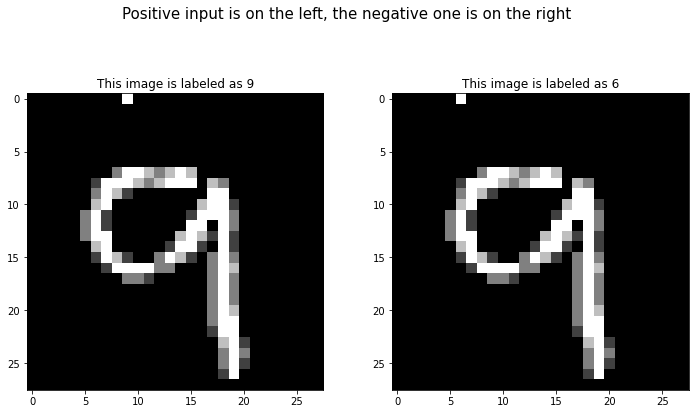

In [5]:
# pick a random image from each set
sample_index = random.choice(range(n))

images = [(x_positive[sample_index], y[sample_index].item()), (x_negative[sample_index], y_random[sample_index].item())]

plt.figure(figsize=(12, 12))

plt.suptitle('Positive input is on the left, the negative one is on the right', fontsize=15)

for idx, (image, label) in enumerate(images):
    plt.subplot(2, 2, idx + 1)
    plt.imshow(image.reshape((d, d)), cmap="gray")
    plt.title(f"This image is labeled as {label}")
plt.show()

### Building the Neural Network

Concerning the architecture of the network, and as some of the experiments done by Hinton, we will use a fully-connected network with 2 hidden layers and 700 neurons in each layer (Hinton used 2000 units and 4 layers, we reduced the size for computational reasons).<br>
For memory issues with *cuda*, one might reduce the size of units per layer or train the network by batches.<br>
Here some options to fix during the training phase :

In [6]:
from enum import Enum

# fixing some options
class HyperParameters(Enum):
    UNITS_PER_LAYER = 700
    EPOCHS_PER_LAYER = 1000
    LEARNING_RATE =  0.03
    THETA = 2.0


The main mechanics are performed inside each layer. In other words, each layer has an optimizer and a training process.

In [7]:
# defining the layer
class DenseLayer(nn.Linear):
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)

        self.relu = nn.ReLU(True)
        # an optimizer for each layer
        self.optimizer = optim.Adam(self.parameters(), lr=HyperParameters.LEARNING_RATE.value)
        # the threshold
        self.theta = HyperParameters.THETA.value
        
    def forward(self, x):
        x = F.normalize(x)
        return self.relu(x@self.weight.T + self.bias)
    
    def goodness(self, x):
        return self.forward(x).pow(2).mean(1)
    
    def logits(self, g_plus, g_minus):
        return torch.log(1 + torch.exp(torch.cat([-g_plus + self.theta, g_minus - self.theta]))).mean()
    
    def loss(self, x_pos, x_neg):
        return self.logits(self.goodness(x_pos), self.goodness(x_neg))
        
    def train(self, x_pos, x_neg):
        loss_per_layer = list()

        for step in range(HyperParameters.EPOCHS_PER_LAYER.value):
            
            self.optimizer.zero_grad()
            
            los = self.loss(x_pos, x_neg)
            loss_per_layer.append(los.item())
            los.backward()
            
            self.optimizer.step()
            
        return self.forward(x_pos).detach(), self.forward(x_neg).detach(), loss_per_layer


Now let's create our neural network based on the structure of the defined layer :

In [8]:
# defining the network
class FCNetwork(nn.Module):
    
    def __init__(self, dimensions):
        super().__init__()
        
        self.layers = list()
        for l in range(len(dimensions) - 1):
            self.layers.append(DenseLayer(dimensions[l], dimensions[l+1]).cuda())
            
    def train(self, x_positive, x_negative):
        x_layer_positive, x_layer_negative = x_positive, x_negative
        print(f">>>>>>>>>>>>>>>>> Training..")
        for l, layer in enumerate(self.layers, 1):
            x_layer_positive, x_layer_negative, loss = layer.train(x_layer_positive, x_layer_negative)

            plt.plot(loss)
            plt.title(f"Evolution of the loss over the layer {l}")
            plt.xlabel("Steps")
            plt.ylabel("Loss")
            plt.show()
                

### Training the Network

In [9]:
# get the appropriate diemensions
x_positive, x_negative = x_positive.reshape((n, d*d)).cuda(), x_negative.reshape((n, d*d)).cuda()

In [10]:
# instantiate the network
hl_size = HyperParameters.UNITS_PER_LAYER.value
network = FCNetwork([d*d, hl_size, hl_size])

>>>>>>>>>>>>>>>>> Training..


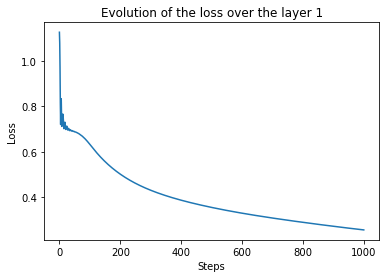

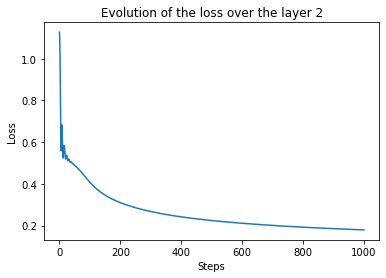

In [11]:
# fit
network.train(x_positive, x_negative)

### Inference

Now, after training, let's see how we can make predictions. In order to do so, we will compute the goodness for each label and choose the one with highest value :

In [12]:
# function that adds a label to the images
def embed_labels(x, label):
    x_embed = x.clone()
    maxi = x.max()
    x_embed[range(x.shape[0]), 0, 0, label] = maxi
    return x_embed

# function that computes local goodness
def layer_goodness(z):
    return z.pow(2).mean(1)

In [13]:
global_goodness = list()

for label in range(10):
    local_goodness = list()
    x_test_layer =  embed_labels(x_test, label).reshape((m, d*d)).cuda()
    for layer in network.layers:
        x_test_layer = layer(x_test_layer)
        local_goodness.append(layer_goodness(x_test_layer))
    global_goodness.append(sum(local_goodness).unsqueeze(1))
goodness_per_label = torch.cat(global_goodness, 1)

In [14]:
y_pred = goodness_per_label.argmax(1)

In [15]:
print(f"Accuracy = {sum(y_pred == y_test.cuda()).item()/m:.3f}")

Accuracy = 0.931


This value can be improved by conducting more experiments and some advanced fine tuning.


## References

[1] : Hinton G., (2022), "The Forward-Forward Algorithm: Some Preliminary Investigations", https://www.cs.toronto.edu/~hinton/FFA13.pdf <br>
[2] : https://github.com/mohammadpz/pytorch_forward_forward